Filtering and splitting up the arxiv and vixra data into various sets

In [1]:
# numpy: linear algebra.
import numpy as np

# pandas: tabular data.
import pandas as pd
pd.set_option('float_format', '{:f}'.format)

# matplotlib and seaborn: plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

In [2]:
# We will use a set random seed when calling df.sample for reproducibility
PD_RANDOM_STATE = 1

In [3]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing .py modules stored in FOLDERNAME or a subdirectory:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Copy and unzip the data to the local directory

In [4]:
# Quick check if data is already mounted.
!ls

drive  sample_data


In [5]:
arxiv_file = 'arxiv_raw.feather'
vixra_file = 'vixra_raw.feather'
arxiv_path = FOLDERNAME + 'data/' + arxiv_file
vixra_path = FOLDERNAME + 'data/' + vixra_file

!cp '{arxiv_path}' .
!cp '{vixra_path}' .

Only read in the identifier, title, and abstract from the data.

In [6]:
arxiv_raw_df = pd.read_feather('arxiv_raw.feather', use_threads=True, columns=['id', 'title', 'abstract'])
vixra_raw_df = pd.read_feather('vixra_raw.feather', use_threads=True, columns=['file_name', 'title', 'abstract'])

Drop duplicate entries based on titles and abstracts

In [7]:
arxiv_raw_no_dups_df = arxiv_raw_df.drop_duplicates(subset=['title', 'abstract']).copy()
vixra_raw_no_dups_df = vixra_raw_df.drop_duplicates(subset=['title', 'abstract']).copy()

Inspect what was dropped.

In [8]:
arxiv_raw_duplicates_df = arxiv_raw_df.drop(arxiv_raw_no_dups_df.index)

In [9]:
vixra_raw_duplicates_df =vixra_raw_df.drop(vixra_raw_no_dups_df.index)

In [10]:
# Merge to get all duplicated entries with identifiers
vixra_raw_duplicates_df = vixra_raw_duplicates_df.merge(vixra_raw_no_dups_df, on=['title', 'abstract'], how='inner').sort_values('title')
arxiv_raw_duplicates_df = arxiv_raw_duplicates_df.merge(arxiv_raw_no_dups_df, on=['title', 'abstract'], how='inner').sort_values('title')

Some of the vixra examples are just the same paper submitted multiple times, like [here](https://vixra.org/abs/1602.0117) and [here](https://vixra.org/abs/1705.0420).

In [11]:
vixra_raw_duplicates_df.head()

,file_name_x,title,abstract,file_name_y
0,vixra.1202.0061,(This Paper Has Been Withdrawn by the Author),This paper has been withdrawn by the author du...,vixra.1202.0063
1,vixra.1205.0077,(This Paper Has Been Withdrawn by the Author),This paper has been withdrawn by the author du...,vixra.1202.0063
15,vixra.1808.0278,A Family of Estimators of Population Mean Usin...,This paper proposes a family of estimators of ...,vixra.1609.0180
17,vixra.1906.0323,A Reformulation of Classical Mechanics,This paper presents a reformulation of classic...,vixra.1503.0049
13,vixra.1706.0090,An Holomorphic Study Of Smarandache Automorphi...,By studying the holomorphic structure of autom...,vixra.1510.0165


The arxiv also has interesting examples, like [this one](https://arxiv.org/abs/1712.01655) which is a withrdrawn duplicate of [this](https://arxiv.org/abs/1712.01655), as detailed in the comment, for whatever reason

In [12]:
arxiv_raw_duplicates_df.head()

,id_x,title,abstract,id_y
217,2006.13685,(Un)conscious Bias in the Astronomical Profess...,(Un)conscious bias affects every aspect of t...,1907.05261
13,0712.0772,3D SPH simulations of grain growth in protopla...,We present the first results of the treatmen...,0709.3070
271,hep-ph/9505403,A New Physics Source of Hard Gluons in Top Qua...,We consider the contribution of new strongly...,hep-ph/9504403
67,1008.1671,A Parsing Scheme for Finding the Design Patter...,Because of the importance of object oriented...,1006.1182
194,1712.01655,A Pitfall of Unsupervised Pre-Training,The point of this paper is to question typic...,1703.04332


Homogenize the data by giving the arxiv data a `file_name` column in the same style as the vixra one

In [13]:
arxiv_raw_no_dups_df['file_name'] = arxiv_raw_no_dups_df['id'].apply(lambda s: 'arxiv.' + s.replace('/', '.'))

Delete the `id` column from the arxiv data, add `source` columns to the dfs, and merge.

In [14]:
del arxiv_raw_no_dups_df['id']

In [15]:
arxiv_raw_no_dups_df['source'] = pd.Series('arxiv' for _ in range(len(arxiv_raw_no_dups_df)))
vixra_raw_no_dups_df['source'] = pd.Series('vixra' for _ in range(len(vixra_raw_no_dups_df)))

In [16]:
data_df = arxiv_raw_no_dups_df.append(vixra_raw_no_dups_df, ignore_index=True)

Turn the `source` column into a `pd.Categorical` object

In [17]:
data_df['source'] = pd.Categorical(data_df['source'])

The data ratio is arxiv:vixra :: 50:1.

In [18]:
(data_df['source'] == 'vixra').mean()

0.019705634865965178

The data ratio is arxiv:vixra :: 50:1.


Create a balanced subset of the raw data for initial exploration



In [19]:
# Take all the vixra files and add equally many randomly selected arxiv files
balanced_sample_df = data_df[data_df['source'] == 'vixra'].copy()
arxiv_random_subset = data_df[data_df['source'] == 'arxiv'].copy().sample(len(balanced_sample_df), random_state=PD_RANDOM_STATE)
# Keep indices intact (ignore_index=False) when appending
balanced_sample_df = balanced_sample_df.append(arxiv_random_subset)
# Test the splitting
(balanced_sample_df['source'] == 'vixra').mean()

0.5

# Visualization

Add the following columns to the dataframe:
* Titles and abstract word counts
* Titles and abstract character counts
* Titles and abstract average word lengths
* Abstract word length variance
* Fraction of numerical characters in abstract
* A source column for an arxiv/vixra flag

For character counts we don't want to count spaces or new-line characters, so we strip, split, rejoin, then count.

In [20]:
balanced_sample_df['title_char_len'] = balanced_sample_df['title'].apply(lambda x: len(''.join(x.strip().split())))
balanced_sample_df['abstract_char_len'] = balanced_sample_df['abstract'].apply(lambda x: len(''.join(x.strip().split())))
balanced_sample_df['title_word_count'] = balanced_sample_df['title'].apply(lambda x: len(x.strip().split()))
balanced_sample_df['abstract_word_count'] = balanced_sample_df['abstract'].apply(lambda x: len(x.strip().split()))
balanced_sample_df['abstract_avg_word_len'] = balanced_sample_df['abstract_char_len'] / balanced_sample_df['abstract_word_count']
balanced_sample_df['title_avg_word_len'] = balanced_sample_df['title_char_len'] / balanced_sample_df['title_word_count']
balanced_sample_df['abstract_numerical_fraction'] = balanced_sample_df['abstract'].apply(lambda x: sum(ch.isdigit() for ch in x)) / balanced_sample_df['abstract_char_len']
balanced_sample_df['abstract_word_len_var'] = balanced_sample_df['abstract'].apply(lambda x: np.array([len(item) for item in x.strip().split()]).var())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice
  


Visualize the distribution of title and abstract lengths for some large sample size.

#Linear plot: word counts

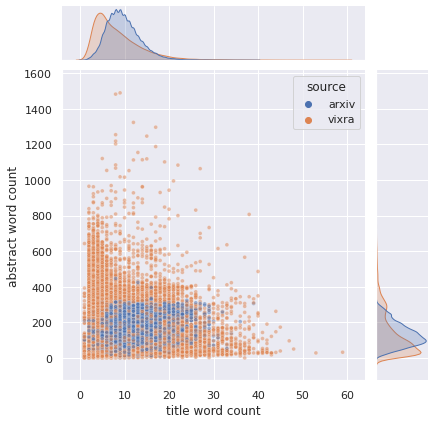

In [22]:
# Commented out for speed

# Do some pruning of outliers for a better plot
plot_data = balanced_sample_df[(balanced_sample_df['abstract_word_count'] < 1500) & (balanced_sample_df['title_word_count'] < 60)]
# Use .sample() for random plot ordering.
title_abstract_word_count_plot = sns.jointplot(data=plot_data.sample(len(plot_data), random_state=PD_RANDOM_STATE), 
                                        x='title_word_count',
                                        y='abstract_word_count',
                                        hue='source',
                                        hue_order = ['arxiv', 'vixra'],
                                        joint_kws = {'s': 15, 'alpha': .5})
title_abstract_word_count_plot.set_axis_labels('title word count', 'abstract word count')
title_abstract_word_count_plot.fig.savefig(FOLDERNAME + 'figures/title_abstract_word_count_plot.png')

Linear plot: char len

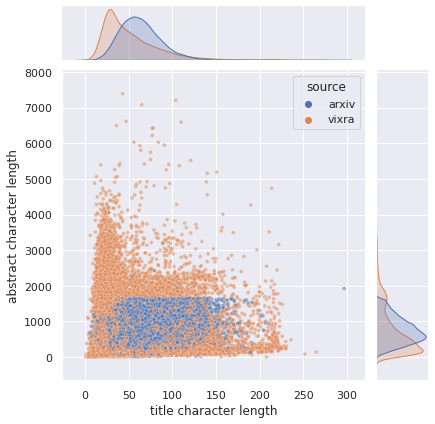

In [23]:
# Commented out for speed

# Do some pruning of outliers for a better plot
plot_data = balanced_sample_df[(balanced_sample_df['abstract_char_len'] < 7500) & (balanced_sample_df['title_char_len'] < 300)]
# Use .sample() for random plot ordering.
title_abstract_char_len_plot = sns.jointplot(data=plot_data.sample(len(plot_data), random_state=PD_RANDOM_STATE), 
                                        x='title_char_len',
                                        y='abstract_char_len',
                                        hue='source',
                                        hue_order = ['arxiv', 'vixra'],
                                        joint_kws = {'s': 15, 'alpha': .5})
title_abstract_char_len_plot.set_axis_labels('title character length', 'abstract character length')
title_abstract_char_len_plot.fig.savefig(FOLDERNAME + 'figures/title_abstract_char_len_plot.png')

There seems to be a nearly hard cutoff on arxiv abstract lengths around 1920 if spaces and \n's are counted, or 1600 if they're not.

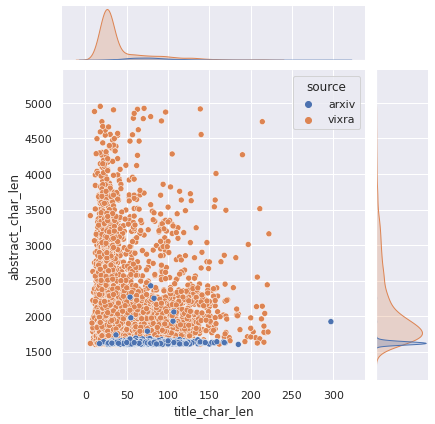

In [24]:
# Commented out for speed

sns.jointplot(data=balanced_sample_df[(balanced_sample_df['abstract_char_len'] > 1600) & (balanced_sample_df['abstract_char_len'] < 5000)], 
                                        x='title_char_len',
                                        y='abstract_char_len',
                                        hue='source')

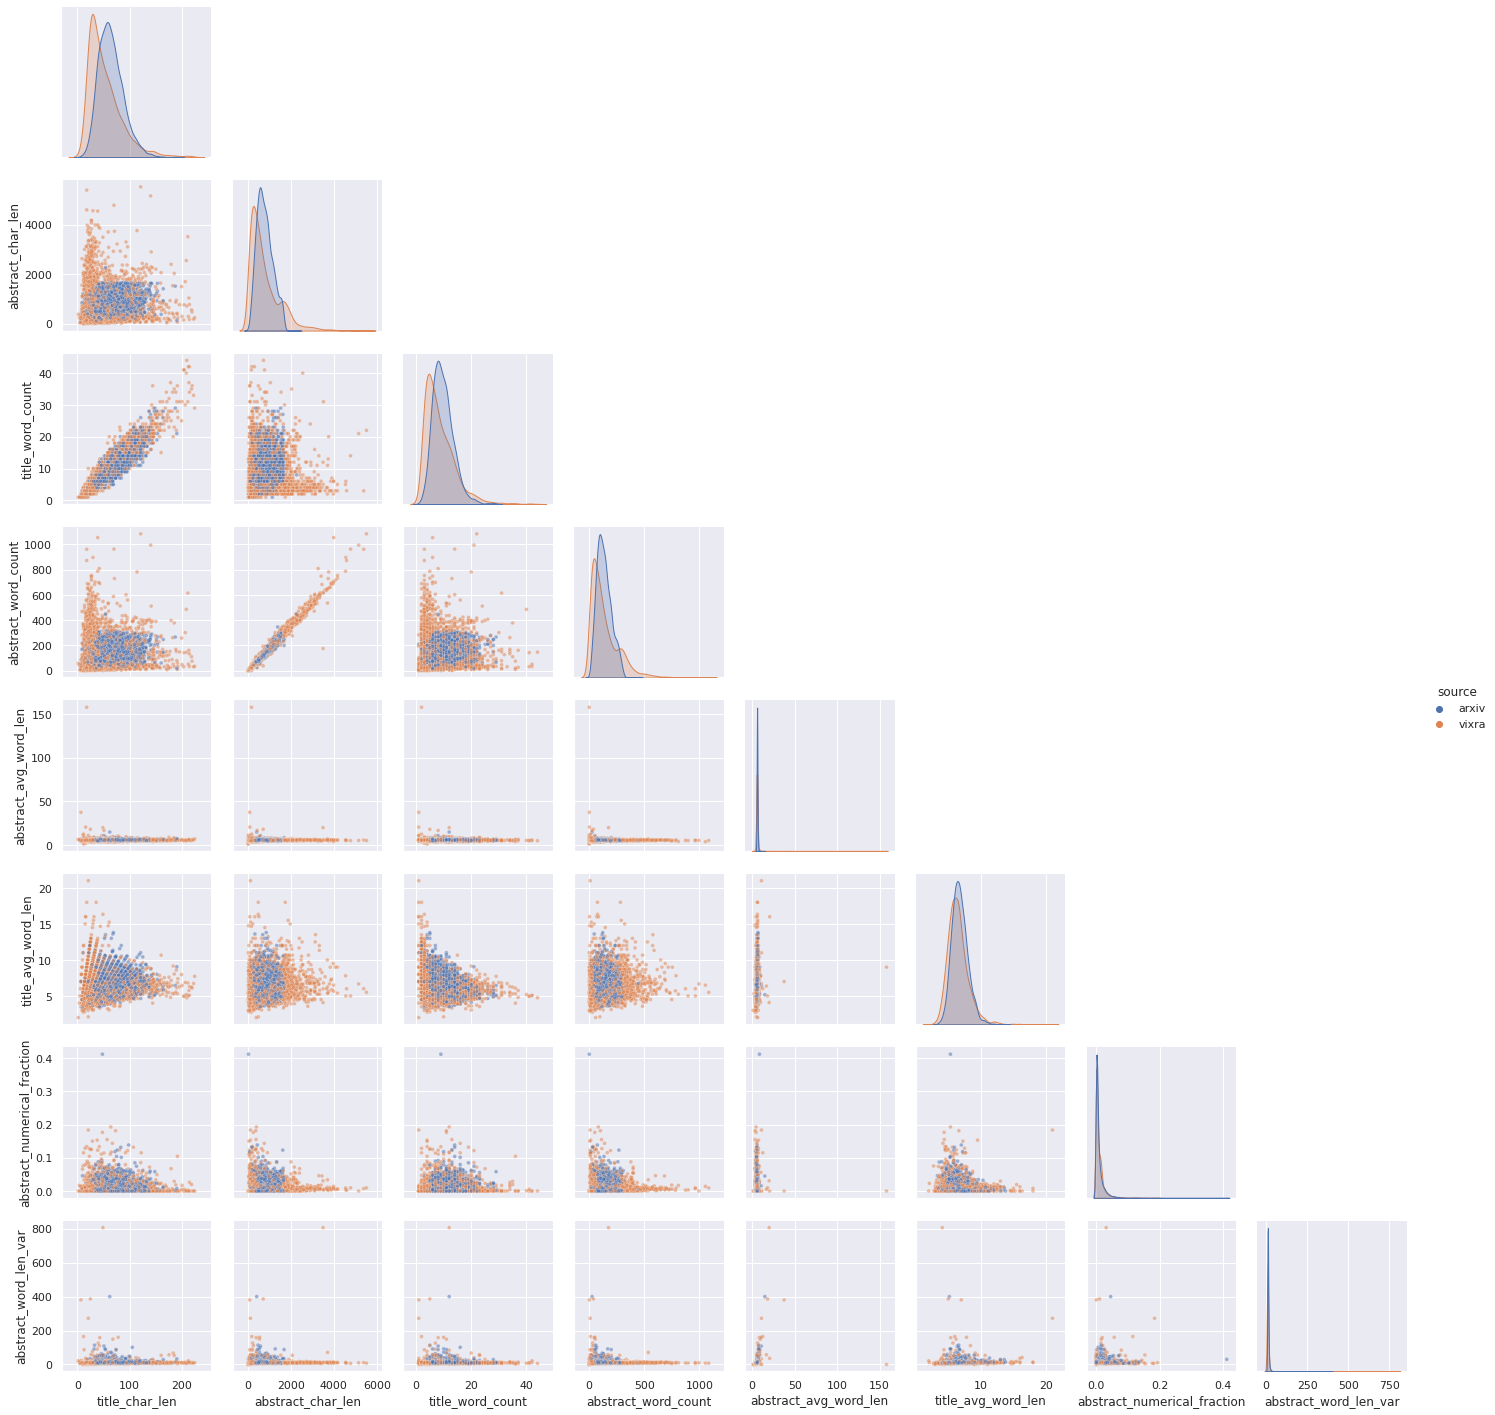

In [25]:
# Pair plot is a bit useless due to outliers.   
sns.pairplot(data = balanced_sample_df.sample(frac=.1, random_state=PD_RANDOM_STATE),
             hue = 'source',
             hue_order = ['arxiv', 'vixra'],
             plot_kws= {'s': 15, 'alpha': .5},
             corner=True)

## Outlier Examination

Examining extremely long or short titles and abstracts

In [26]:
arxiv_balanced_data = balanced_sample_df[balanced_sample_df['source'] == 'arxiv']
vixra_balanced_data = balanced_sample_df[balanced_sample_df['source'] == 'vixra']

Start with the arxiv

In [27]:
arxiv_balanced_data_longest_title = arxiv_balanced_data.sort_values('title_char_len')[:-10:-1]
for s in arxiv_balanced_data_longest_title['title']:
    print(s, len(s), '\n ----------- \n', sep='\n')

Influence of proteins from physiological solutions on the
  electrochemical behaviour of the Ti-6Al-4V alloy: reproducibility and
  time-frequency dependence. ---- Influence de la teneur en prot\'eines de
  solutions physiologiques sur le comportement \'electrochimique du Ti-6Al-4V :
  reproductibilit\'e et repr\'esentation temps-fr\'equence
343

 ----------- 

Synthesizing multi-layer perceptron network with ant lion,
  biogeography-based dragonfly algorithm evolutionary strategy invasive weed
  and league champion optimization hybrid algorithms in predicting heating load
  in residential buildings
242

 ----------- 

A Comparative study of Artificial Neural Networks Using Reinforcement
  learning and Multidimensional Bayesian Classification Using Parzen Density
  Estimation for Identification of GC-EIMS Spectra of Partially Methylated
  Alditol Acetates
240

 ----------- 

Determination of the quarkonium--gluonium content of the isoscalar
  tensor resonances $f_2(1920)$, $f_2(2020)$,

In [28]:
arxiv_balanced_data_shortest_title = arxiv_balanced_data.sort_values('title_char_len')[:10]
for s in arxiv_balanced_data_shortest_title['title']:
    print(s, len(s), '\n ----------- \n', sep='\n')

Masers
6

 ----------- 

0-1 laws
8

 ----------- 

FAQBism
7

 ----------- 

GCA in 2d
9

 ----------- 

Diamonds
8

 ----------- 

Q-branes
8

 ----------- 

NSUSY fits
10

 ----------- 

ADE and SLE
11

 ----------- 

SOT for MOT
11

 ----------- 

Pseudo PCF
10

 ----------- 



In [29]:
arxiv_balanced_data_shortest_abstract = arxiv_balanced_data.sort_values('abstract_char_len')[:10]
for s in arxiv_balanced_data_shortest_abstract['abstract']:
    print(s, len(s), '\n ----------- \n', sep='\n')

  See hep-ph/0304045

21

 ----------- 

  Withdrawn by the authors

27

 ----------- 

  Witdrawn. Error in Eq.(14).

30

 ----------- 

  This paper has been withdrawn

32

 ----------- 

  This paper has been withdrawn.

33

 ----------- 

  This paper has been withdrawn.

33

 ----------- 

  This paper has been withdrawn.

33

 ----------- 

  This paper has been withdrawn.

33

 ----------- 

  We present a history of Hoare's logic.

41

 ----------- 

  Bourbaki seminar 1062, October 2012.

39

 ----------- 



In [30]:
# These are way too long.
arxiv_balanced_data_longest_abstract = arxiv_balanced_data.sort_values('abstract_char_len')[:-2:-1]
for s in arxiv_balanced_data_longest_abstract['abstract']:
    print(s, len(s),  '\n ----------- \n', sep='\n')

  During recent years, the renaissance of neural networks as the major machine
learning paradigm and more specifically, the confirmation that deep learning
techniques provide state-of-the-art results for most of computer vision tasks
has been shaking up traditional research in image processing. The same can be
said for research in communities working on applied harmonic analysis,
information geometry, variational methods, etc. For many researchers, this is
viewed as an existential threat. On the one hand, research funding agencies
privilege mainstream approaches especially when these are unquestionably
suitable for solving real problems and for making progress on artificial
intelligence. On the other hand, successful publishing of research in our
communities is becoming almost exclusively based on a quantitative improvement
of the accuracy of any benchmark task. As most of my colleagues sharing this
research field, I am confronted with the dilemma of continuing to invest my
time and in

Then vixra.

In [31]:
vixra_balanced_data_longest_title = vixra_balanced_data.sort_values('title_char_len')[:-10:-1]
for s in vixra_balanced_data_longest_title['title']:
    print(s, len(s), '\n ----------- \n', sep='\n')

The $abc$ Conjecture: the Proof of $c
Authors: Abdelmajid Ben Hadj Salem
Comments: 9 Pages. Submitted to the journal Annals of Mathematics.

In this note, I present a very elementary proof of the conjecture $c<rad^2(abc)$ that constitutes the key to resolve the $abc$ conjecture. The method concerns the comparison of the number of primes of $c$ and $rad^2(abc)$ for large $a,b,c$ using the prime counting function $\pi(x)$ giving the number of primes $\leq x$. Some numerical examples are given.
  
Category: Number Theory
525

 ----------- 

Assuming C
Authors: Abdelmajid Ben Hadj Salem
Comments: 6 Pages. Submitted to the journal of London Mathematical Society. Comments welcome.

In this paper about the abc conjecture, we propose a new conjecture about an upper bound for c as c0, for a,b,c positive integers relatively prime with c=a+b, we have c< K(\epsilon).rad^{1+\epsilon}(abc). Some numerical examples are given.
  
Category: Number Theory
409

 ----------- 

Assuming C
Authors: Abdelmaj

In [32]:
vixra_balanced_data_shortest_title = vixra_balanced_data.sort_values('title_char_len')[:10]
for s, f in zip(vixra_balanced_data_shortest_title['title'], vixra_balanced_data_shortest_title['file_name']):
    print(s, f, '\n ----------- \n', sep='\n')

1
vixra.1709.0119

 ----------- 

1
vixra.1702.0059

 ----------- 

14
vixra.1707.0181

 ----------- 

137
vixra.1710.0234

 ----------- 

P ≠ NP
vixra.1806.0225

 ----------- 

Mr. Y
vixra.2003.0104

 ----------- 

Heat
vixra.1801.0095

 ----------- 

Test
vixra.1805.0191

 ----------- 

Mond
vixra.1811.0408

 ----------- 

Kuku
vixra.1808.0048

 ----------- 



In [33]:
# There are blank abstracts in the vixra set
vixra_balanced_data_shortest_abstract = vixra_balanced_data.sort_values('abstract_char_len')[:10]
for s, f in zip(vixra_balanced_data_shortest_abstract['abstract'], vixra_balanced_data_shortest_abstract['file_name']):
    print(s, f, '\n ----------- \n', sep='\n')


vixra.2104.0040

 ----------- 


vixra.1006.0038

 ----------- 


vixra.1702.0287

 ----------- 


vixra.1904.0329

 ----------- 

.
vixra.1802.0045

 ----------- 

1
vixra.1702.0059

 ----------- 

.
vixra.1708.0097

 ----------- 

1
vixra.1702.0311

 ----------- 

t
vixra.1207.0040

 ----------- 

no
vixra.1702.0162

 ----------- 



In [34]:
# These are way too long.
vixra_balanced_data_longest_abstract = vixra_balanced_data.sort_values('abstract_char_len')[:-3:-1]
for s in vixra_balanced_data_longest_abstract['abstract']:
    print(s, len(s), '\n ----------- \n', sep='\n')

Preface

Even a cursory reading of Hegel’s works is sufficient to convince one that the categories of quality and quantity, the concepts of space, time, place are basic to the system. In contrast with Aristotle and Kant, Hegel’s speculative logic exhibits a presuppositionless derivation of the categories. Hegel regards his categories, concepts and notions not as completed and frozen. For him, the categories must be derived, not from presupposed forms of judgement, or from our presuppositions, but from what he calls the sheer ‘simplicity of thinking’, from the indeterminate being of thought and from the indeterminate thought of being. 

Hegel’s categories of quality and quantity, in particular ‘qualitative quantity’ in relation with his concepts of space, time, place are subject to which much attention has not been paid by Hegel’s expositors and commentators and yet the importance of it cannot be denied. (Haldar,1932). 

Topological reading of ‘qualitative quantity’ within Hegel’s fourf

Some of the vixra entires have super long words, seemingly.  In the majority of the cases, it's because the abstract is in Chinese, which does not include spaced between words.

In [35]:
vixra_balanced_data_long_words = vixra_balanced_data[vixra_balanced_data['abstract_avg_word_len'] > 15]
arxiv_balanced_data_long_words = arxiv_balanced_data[arxiv_balanced_data['abstract_avg_word_len'] > 15]
print(len(vixra_balanced_data_long_words), len(arxiv_balanced_data_long_words))

49 1


In [36]:
vixra_balanced_data_long_words.head()

,title,abstract,file_name,source,title_char_len,abstract_char_len,title_word_count,abstract_word_count,abstract_avg_word_len,title_avg_word_len,abstract_numerical_fraction,abstract_word_len_var
1904764,Chinese Put Fermat Last Theorem for Wiles is a...,中国人把费马大定理成果送绐Wiles是犯罪,vixra.1209.0036,vixra,43,21,10,1,21.000000,4.300000,0.000000,0.000000
1904929,The More Simple Proof of Fermat Last Theorem,用最简单初等数学证明了费马大定理,vixra.1210.0027,vixra,37,16,8,1,16.000000,4.625000,0.000000,0.000000
1905542,Mobile Robot Navigation Using Artificial Landm...,移動ロボットのナビゲーションを行うにはロボットが\r\n十分に現在位置と周囲の環境を認識する...,vixra.1303.0202,vixra,51,417,8,25,16.680000,6.375000,0.004796,57.177600
1909542,The Formula of π(N),The formula of prime-counting function π(N=6n+...,vixra.1408.0041,vixra,16,274,4,16,17.125000,4.000000,0.171533,248.484375
1909786,无穷大的运算法则,传统数论中的无穷大是没有上界的，也就是没有最大，只有更大。无穷大是自相矛盾的。,vixra.1409.0003,vixra,8,39,1,1,39.000000,8.000000,0.000000,0.000000


So, we see various issues with the vixra text.  

In [37]:
# Items with no abstract
len(vixra_balanced_data[vixra_balanced_data['abstract_char_len']==0])

4

More summary stats

In [38]:
vixra_balanced_data.describe()

,title_char_len,abstract_char_len,title_word_count,abstract_word_count,abstract_avg_word_len,title_avg_word_len,abstract_numerical_fraction,abstract_word_len_var
count,38219.000000,38219.000000,38219.000000,38219.000000,38215.000000,38219.000000,38215.000000,38215.000000
mean,52.072974,762.331877,8.462754,137.966587,5.628745,6.467757,0.008481,12.390906
std,32.969525,722.172386,5.567712,130.442966,4.143327,1.898724,0.019057,119.282992
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,29.000000,245.000000,4.000000,44.000000,5.160000,5.400000,0.000000,8.715197
50%,43.000000,525.000000,7.000000,96.000000,5.528090,6.230769,0.001303,10.347755
75%,67.000000,1070.000000,11.000000,194.000000,5.848012,7.200000,0.011711,12.056860
max,438.000000,13831.000000,82.000000,2357.000000,385.000000,101.000000,1.000000,21938.000000


In [39]:
arxiv_balanced_data.describe()

,title_char_len,abstract_char_len,title_word_count,abstract_word_count,abstract_avg_word_len,title_avg_word_len,abstract_numerical_fraction,abstract_word_len_var
count,38219.000000,38219.000000,38219.000000,38219.000000,38219.000000,38219.000000,38219.000000,38219.000000
mean,63.303435,768.905492,9.660064,134.962872,5.717979,6.713403,0.007505,12.592415
std,23.360003,363.086195,3.734964,64.212706,0.489268,1.300312,0.013497,7.772947
min,6.000000,17.000000,1.000000,2.000000,3.545455,2.333333,0.000000,1.440000
25%,47.000000,491.500000,7.000000,86.000000,5.403347,5.833333,0.000000,9.983340
50%,61.000000,722.000000,9.000000,127.000000,5.700000,6.600000,0.002020,11.487740
75%,77.000000,1014.000000,12.000000,177.000000,6.006494,7.444444,0.009499,13.426459
max,297.000000,2426.000000,39.000000,447.000000,15.480000,25.666667,0.411765,701.929600


Let's try also filtering titles by the percent of characters which are alphabetical, numeric, greek, or are in puctuation.

In [40]:
from string import punctuation, ascii_lowercase

In [41]:
greek_chars=''.join(chr(code) for code in range(945,970))
print(greek_chars)

αβγδεζηθικλμνξοπρςστυφχψω


In [42]:
def percent_common_chars(s):
    # escaping divide by zero errors
    if not s:
        return 0
    chars = set(' ' + '1234567890' + ascii_lowercase + punctuation + greek_chars)
    count, total = 0, len(s)
    for ch in s:
        if ch.lower() in chars:
            count += 1
    return count / total

Seems to do a pretty good job. Nearly all from vixra.

In [43]:
# Add the computed fractions as new columns
balanced_sample_df['abstract_common_char_frac'] = balanced_sample_df['abstract'].apply(lambda x: percent_common_chars(x))
balanced_sample_df['title_common_char_frac'] = balanced_sample_df['title'].apply(lambda x: percent_common_chars(x))

Choose some fraction to filter by and verify that it doesn't severely filter the data.

In [44]:
common_char_frac = .97
print((balanced_sample_df['abstract_common_char_frac'] < common_char_frac).mean())
print((balanced_sample_df['title_common_char_frac'] < common_char_frac).mean())

0.031057850807190143
0.020631099714801537


Filters out far more vixra than arxiv, as expected.

In [45]:
balanced_sample_df[balanced_sample_df['abstract_common_char_frac'] < common_char_frac]['source'].value_counts()

vixra    2366
arxiv       8
Name: source, dtype: int64

Based on the above, let's create some filters to apply to the data.  See below values for precise filters.

Filter the raw, balanced dataset per the above. Create a small class to do so, since we will need to filter the full dataset later.

In [46]:
class DataFilter():
    """Filtering dataframes based on min and max characteristics.

    `__init__` Args
    ----------
    `df`: `pd.DataFrame` 
        `DataFrame` object to be filtered.
    `filter_min_dic`: `dic`
        Dictionary of key-value pairs to filter over as lower bounds (<=)
    `filter_max_dic`: `dic`
        Dictionary of key-value pairs to filter over as lower bounds (<=)

    Methods
    ----------
    `filter_fracs`
        Returns dictionary of how much data was filtered out by each filter
    `filtered_df`
        Returns a copy of the filtered `DataFrame` object.
    """
    def __init__(self, 
                 df: pd.DataFrame, 
                 filter_min_dic,
                 filter_max_dic):
        self.df = df 
        self.filter_min_dic = filter_min_dic
        self.filter_max_dic = filter_max_dic
        self._applied_filters = {}
        for key, val in self.filter_min_dic.items():
            self._applied_filters['min_' + key] = self.df[key] >= val
        for key, val in self.filter_max_dic.items():
            self._applied_filters['max_' + key] = self.df[key] <= val
        
    def filter_fracs(self):
        filter_fracs = {key: val.mean() for key, val in self._applied_filters.items()}
        return filter_fracs

    def filtered_df(self):
        filter_iter = iter(self._applied_filters.values())
        composite_filter = next(filter_iter)
        for item in filter_iter:
            composite_filter = (composite_filter) & (item)
        filtered_df = self.df[composite_filter]
        print(f'{1 - composite_filter.mean():.3f} fraction of df removed.')
        return filtered_df.copy()

In [47]:
filter_min_dic = {'title_word_count': 1,
                  'title_char_len': 8,
                  'title_avg_word_len': 2,
                  'abstract_word_count': 1,
                  'abstract_char_len': 32,
                  'abstract_avg_word_len': 2,
                  'abstract_word_len_var': 2,
                  'abstract_numerical_fraction': 0.,
                  'abstract_common_char_frac': common_char_frac,
                  'title_common_char_frac': common_char_frac
                  }
filter_max_dic = {'title_word_count': 16,
                  'title_char_len': 128,
                  'title_avg_word_len': 16,
                  'abstract_word_count': 256,
                  'abstract_char_len': 2048,
                  'abstract_avg_word_len': 8,
                  'abstract_word_len_var': 32,
                  'abstract_numerical_fraction': .05
                  }
balanced_sample_filter = DataFilter(balanced_sample_df, filter_min_dic, filter_max_dic)

Check that the filters aren't too severe.

In [48]:
balanced_sample_filter.filter_fracs()

{'max_abstract_avg_word_len': 0.9956566105863576,
 'max_abstract_char_len': 0.9739919935110809,
 'max_abstract_numerical_fraction': 0.9779559904759413,
 'max_abstract_word_count': 0.8877914126481593,
 'max_abstract_word_len_var': 0.9882388340877574,
 'max_title_avg_word_len': 0.9991365551165651,
 'max_title_char_len': 0.9779429079777074,
 'max_title_word_count': 0.934522096339517,
 'min_abstract_avg_word_len': 0.9998691750176614,
 'min_abstract_char_len': 0.9951725581517047,
 'min_abstract_common_char_frac': 0.9689421491928099,
 'min_abstract_numerical_fraction': 0.9999476700070645,
 'min_abstract_word_count': 0.9999476700070645,
 'min_abstract_word_len_var': 0.9983908527172349,
 'min_title_avg_word_len': 0.999895340014129,
 'min_title_char_len': 0.9989795651377587,
 'min_title_common_char_frac': 0.9793689002851984,
 'min_title_word_count': 1.0}

In [49]:
# The filtered data.
balanced_sample_filter.filtered_df().describe()

0.230 fraction of df removed.


,title_char_len,abstract_char_len,title_word_count,abstract_word_count,abstract_avg_word_len,title_avg_word_len,abstract_numerical_fraction,abstract_word_len_var,abstract_common_char_frac,title_common_char_frac
count,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000
mean,54.837976,629.986495,8.484168,111.773425,5.621721,6.607150,0.005528,11.438658,0.989681,0.997036
std,21.931195,354.679994,3.348238,61.978441,0.532580,1.388548,0.009089,3.376127,0.006605,0.005236
min,8.000000,32.000000,1.000000,4.000000,2.586207,2.090909,0.000000,2.000000,0.970000,0.970000
25%,38.000000,353.000000,6.000000,64.000000,5.293103,5.666667,0.000000,9.379663,0.986047,0.992000
50%,53.000000,589.000000,8.000000,105.000000,5.625000,6.500000,0.000000,10.966691,0.986641,1.000000
75%,70.000000,881.000000,11.000000,155.000000,5.951220,7.375000,0.008000,12.859375,0.996554,1.000000
max,128.000000,1713.000000,16.000000,256.000000,8.000000,16.000000,0.050000,31.950582,1.000000,1.000000


Outlier filtering unbalances the dataset again. Removes more vixra articles than arxiv ones, as expected.

In [50]:
(balanced_sample_filter.filtered_df()['source'] == 'arxiv').mean()

0.230 fraction of df removed.


0.5736053543521098

# Filtering Outliers from the Full Dataset

Perform the same filtering. Split into a few cells since this crashes otherwise, I guess for memory reasons.

In [51]:
full_data_df = data_df.copy()
full_data_df['title_char_len'] = full_data_df['title'].apply(lambda x: len(''.join(x.strip().split())))
full_data_df['abstract_char_len'] = full_data_df['abstract'].apply(lambda x: len(''.join(x.strip().split())))
full_data_df['title_word_count'] = full_data_df['title'].apply(lambda x: len(x.strip().split()))

In [52]:
full_data_df['abstract_word_count'] = full_data_df['abstract'].apply(lambda x: len(x.strip().split()))
full_data_df['abstract_avg_word_len'] = full_data_df['abstract_char_len'] / full_data_df['abstract_word_count']
full_data_df['title_avg_word_len'] = full_data_df['title_char_len'] / full_data_df['title_word_count']

In [53]:
full_data_df['abstract_numerical_fraction'] = full_data_df['abstract'].apply(lambda x: sum(ch.isdigit() for ch in x)) / full_data_df['abstract_char_len']
full_data_df['abstract_word_len_var'] = full_data_df['abstract'].apply(lambda x: np.array([len(item) for item in x.strip().split()]).var())
full_data_df['abstract_common_char_frac'] = full_data_df['abstract'].apply(lambda x: percent_common_chars(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice
  


In [54]:
full_data_df['title_common_char_frac'] = full_data_df['title'].apply(lambda x: percent_common_chars(x))

In [55]:
full_data_filter = DataFilter(full_data_df, filter_min_dic, filter_max_dic)

In [56]:
full_data_filter.filter_fracs()

{'max_abstract_avg_word_len': 0.9983475088373475,
 'max_abstract_char_len': 0.9988832150208096,
 'max_abstract_numerical_fraction': 0.9820907081014861,
 'max_abstract_word_count': 0.9514038698713481,
 'max_abstract_word_len_var': 0.9877483634923712,
 'max_title_avg_word_len': 0.999810775582935,
 'max_title_char_len': 0.9890775747926266,
 'max_title_word_count': 0.9508722884708192,
 'min_abstract_avg_word_len': 0.9999948440213334,
 'min_abstract_char_len': 0.9996096924149367,
 'min_abstract_common_char_frac': 0.9985898398346787,
 'min_abstract_numerical_fraction': 0.9999979376085334,
 'min_abstract_word_count': 0.9999979376085334,
 'min_abstract_word_len_var': 0.9999242071136006,
 'min_title_avg_word_len': 0.9999917504341334,
 'min_title_char_len': 0.9998819280885344,
 'min_title_common_char_frac': 0.9991832929792069,
 'min_title_word_count': 1.0}

In [57]:
full_data_filtered_df = full_data_filter.filtered_df()

0.119 fraction of df removed.


In [58]:
full_data_filtered_df.describe()

,title_char_len,abstract_char_len,title_word_count,abstract_word_count,abstract_avg_word_len,title_avg_word_len,abstract_numerical_fraction,abstract_word_len_var,abstract_common_char_frac,title_common_char_frac
count,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000,1708291.000000
mean,60.253584,721.534908,9.085521,126.306162,5.717342,6.767994,0.005676,12.094858,0.986280,0.995481
std,20.190313,325.797919,3.064349,56.495296,0.464881,1.301883,0.009061,3.337375,0.001605,0.005522
min,8.000000,32.000000,1.000000,4.000000,2.586207,2.000000,0.000000,2.000000,0.970000,0.970000
25%,45.000000,473.000000,7.000000,83.000000,5.413333,5.888889,0.000000,9.997810,0.985915,0.989362
50%,59.000000,692.000000,9.000000,121.000000,5.709091,6.666667,0.001392,11.506576,0.986341,1.000000
75%,74.000000,952.000000,11.000000,166.000000,6.013699,7.500000,0.007764,13.393879,0.986657,1.000000
max,128.000000,1720.000000,16.000000,256.000000,8.000000,16.000000,0.050000,32.000000,1.000000,1.000000


# Exporting Data Splits

Generate 70:15:15 :: train:validation:test splits for both a balanced data set and the full data set.

In [59]:
full_data_filtered_arxiv_df  = full_data_filtered_df[full_data_filtered_df['source'] == 'arxiv'].copy()
full_data_filtered_vixra_df  = full_data_filtered_df[full_data_filtered_df['source'] == 'vixra'].copy()

Create a balanced dataset.

In [60]:
# Create a full_data_filtered_vixra_df-sized dataset
full_data_filtered_arxiv_sample_df = full_data_filtered_arxiv_df.sample(len(full_data_filtered_vixra_df), random_state=PD_RANDOM_STATE)

Split the two subsets individually and merge to ensure equal ratios

In [61]:
full_data_filtered_vixra_train_df = full_data_filtered_vixra_df.sample(frac=.7, random_state=PD_RANDOM_STATE)
full_data_filtered_vixra_remainder_df = full_data_filtered_vixra_df.drop(full_data_filtered_vixra_train_df.index)
full_data_filtered_vixra_validation_df = full_data_filtered_vixra_remainder_df.sample(frac=.5, random_state=PD_RANDOM_STATE)
full_data_filtered_vixra_test_df = full_data_filtered_vixra_remainder_df.drop(full_data_filtered_vixra_validation_df.index)

In [62]:
full_data_filtered_arxiv_sample_train_df = full_data_filtered_arxiv_sample_df.sample(frac=.7, random_state=PD_RANDOM_STATE)
full_data_filtered_arxiv_sample_remainder_df = full_data_filtered_arxiv_sample_df.drop(full_data_filtered_arxiv_sample_train_df.index)
full_data_filtered_arxiv_sample_validation_df = full_data_filtered_arxiv_sample_remainder_df.sample(frac=.5, random_state=PD_RANDOM_STATE)
full_data_filtered_arxiv_sample_test_df = full_data_filtered_arxiv_sample_remainder_df.drop(full_data_filtered_arxiv_sample_validation_df.index)

In [63]:
all([len(full_data_filtered_vixra_train_df) == len(full_data_filtered_arxiv_sample_train_df),
     len(full_data_filtered_vixra_validation_df) == len(full_data_filtered_arxiv_sample_validation_df),
     len(full_data_filtered_vixra_test_df) == len(full_data_filtered_arxiv_sample_test_df)
     ])

True

Split

In [64]:
# Creating splits.
balanced_filtered_data_train_df = full_data_filtered_vixra_train_df.append(full_data_filtered_arxiv_sample_train_df)
balanced_filtered_data_validation_df = full_data_filtered_vixra_validation_df.append(full_data_filtered_arxiv_sample_validation_df)
balanced_filtered_data_test_df = full_data_filtered_vixra_test_df.append(full_data_filtered_arxiv_sample_test_df)

Sanity check: datasets should not overlap

In [65]:
balanced_data_intersections = [balanced_filtered_data_train_df.merge(balanced_filtered_data_validation_df, how='inner', on=['title', 'abstract']),
                               balanced_filtered_data_train_df.merge(balanced_filtered_data_test_df, how='inner', on=['title', 'abstract']),
                               balanced_filtered_data_validation_df.merge(balanced_filtered_data_test_df, how='inner', on=['title', 'abstract'])]
assert not any([len(item) for item in balanced_data_intersections]), 'Sanity check failed: datasets overlap!'                               

In [66]:
# Write to disk. 
# Shuffle indices to avoid annoying error messages in pl about having no
# positive/negative examples in validation/test batches.
balanced_filtered_data_train_df.sample(frac=1, random_state=PD_RANDOM_STATE).reset_index(drop=True).to_feather(FOLDERNAME + 'data/data_splits/balanced_filtered_data_train.feather')
balanced_filtered_data_validation_df.sample(frac=1, random_state=PD_RANDOM_STATE).reset_index(drop=True).to_feather(FOLDERNAME + 'data/data_splits/balanced_filtered_data_validation.feather')
balanced_filtered_data_test_df.sample(frac=1, random_state=PD_RANDOM_STATE).reset_index(drop=True).to_feather(FOLDERNAME + 'data/data_splits/balanced_filtered_data_test.feather')

# Full Dataset

Let us assume that in production we mostly be testing on a balanced dataset.  Then let us just create a large training set which uses all data points not included in `balanced_filtered_data_validation_df` and `balanced_filtered_data_test_df`.

In [67]:
large_filtered_data_train_df = full_data_filtered_df.drop(balanced_filtered_data_validation_df.index).drop(balanced_filtered_data_test_df.index)

In [68]:
# Gross count of vixra papers remaining
print(sum(large_filtered_data_train_df['source'] == 'vixra'))

17571


Sanity check:

In [69]:
large_filtered_data_train_intersections = [large_filtered_data_train_df.merge(balanced_filtered_data_validation_df, how='inner', on=['title', 'abstract']),
                                       large_filtered_data_train_df.merge(balanced_filtered_data_test_df, how='inner', on=['title', 'abstract'])]
assert not any([len(item) for item in large_filtered_data_train_intersections]), 'Sanity check failed: datasets overlap!'                               

In [70]:
# Write to disk.
large_filtered_data_train_df.sample(frac=1, random_state=PD_RANDOM_STATE).reset_index(drop=True).to_feather(FOLDERNAME + 'data/data_splits/large_filtered_data_train.feather')

# Visualizing the Balanced, Filtered Data

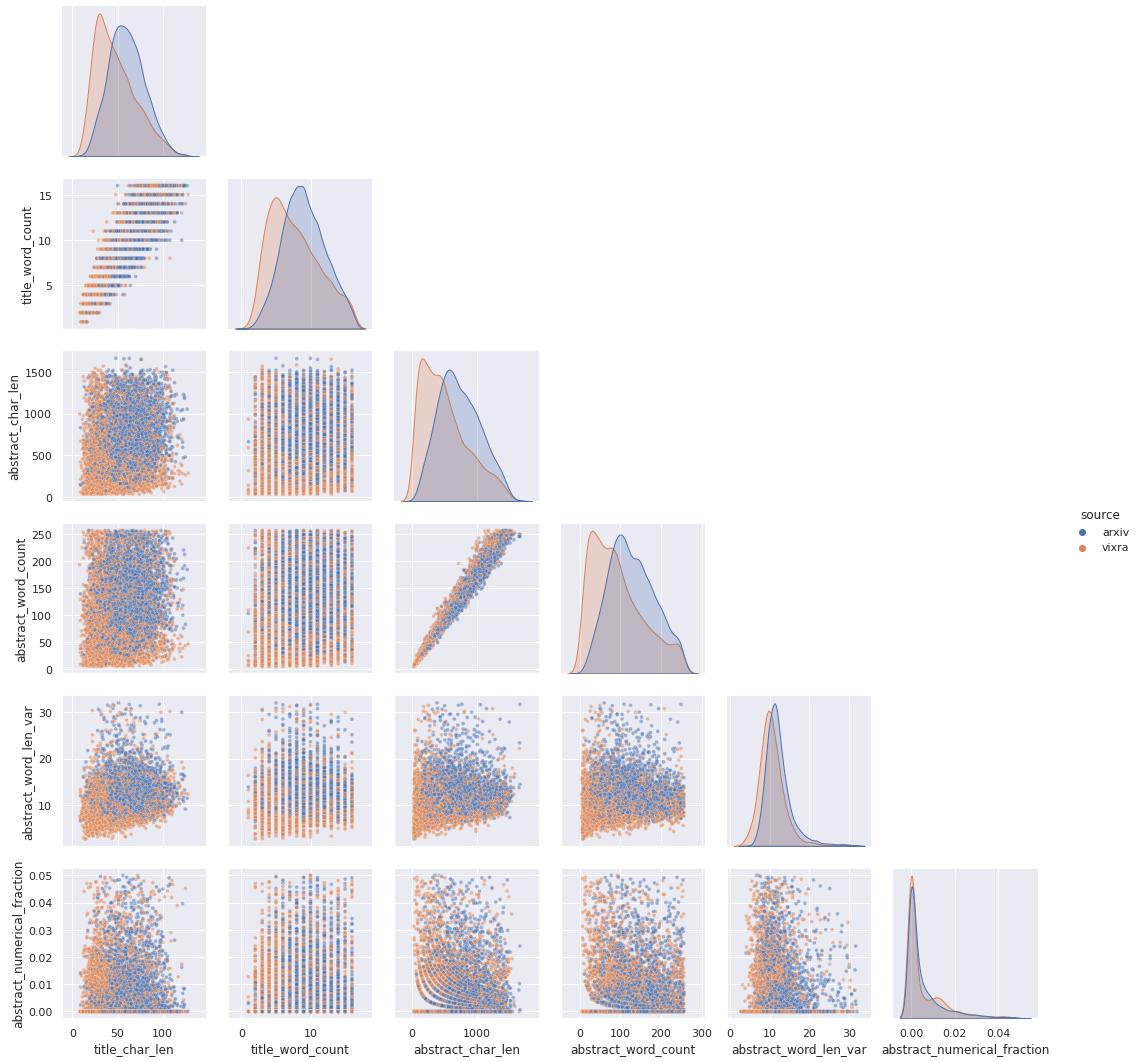

In [74]:
# Because the average word lengths are not independent information, omit them.
plot_vars = ['title_char_len', 
             'title_word_count',
             'abstract_char_len',
             'abstract_word_count',
             'abstract_word_len_var','abstract_numerical_fraction']
balanced_filtered_data_df_pairplot = sns.pairplot(data = balanced_filtered_data_train_df.sample(frac=.25, random_state=PD_RANDOM_STATE),
             hue = 'source',
             hue_order = ['arxiv', 'vixra'],
             x_vars = plot_vars,
             y_vars = plot_vars,
             plot_kws= {'s': 15, 'alpha': .5},
             corner=True)
balanced_filtered_data_df_pairplot.fig.savefig(FOLDERNAME + 'figures/balanced_filtered_data_df_pairplot.png')